In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Fit principa axis via SVD
def fitsvd (xpoints, ypoints, zpoints):
    x = np.array(xpoints)
    y = np.array(ypoints)
    z = np.array(zpoints)

    data = np.concatenate((x[:, np.newaxis], 
                           y[:, np.newaxis], 
                           z[:, np.newaxis]), 
                          axis=1)

    # Calculate the mean of the points, i.e. the 'center' of the cloud
    datamean = data.mean(axis=0)

    # Do an SVD on the mean-centered data.
    uu, dd, vv = np.linalg.svd(data - datamean)

    # Now vv[0] contains the first principal component, i.e. the direction
    # vector of the 'best fit' line in the least squares sense.

    # dd[0] contains the singlar value corresponding to vv[0], so the RMS
    # _along_ that principal component - i.e. the RMS length

    dir = np.array([vv[0][0],vv[0][1],vv[0][2]])
    return dir, dd, datamean


# Plot a charge distribution as well as the initial direction (label)
def plot_track_dir(x_points, y_points, z_points, start, direction):

    # Plot the track
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(x_points, y_points, z_points, c='k', marker='o')

    ax.set_xlabel('x [cm]')
    ax.set_ylabel('y [cm]')
    ax.set_zlabel('z [cm]')
    plt.tight_layout()

    # Add red line for true direction (z direction)
    #ax.plot3D([vector_tail[0],vector_head[0]], [vector_tail[1],vector_head[1]], [vector_tail[2],vector_head[2]], c='r')
    ax.quiver(start[0],start[1],start[2],direction[0],direction[1],direction[2], linewidths=3, color = 'red')

    plt.show()


In [3]:
# Specify location of data file
data_loc = '/Users/majdghrear/data/e_dir_fit'

# The data is stored in 100 pickle files each containing 10k electron recoil simulations
files_e = [data_loc+'/processed_training_data/50_keV/processed_recoils_'+str(i)+'.pk' for i in range(1) ]

In [4]:
df = pd.read_pickle(files_e[0])
df.head()

,x,y,z,dir,offset,diff
0,"[0.21813755820438174, 0.32602425244757016, 0.2...","[0.2095204013215044, -2.4041257503080957, -2.4...","[0.17033487024701915, -0.10929949473715965, -0...","[0.026361450114195585, 0.8711186313268745, -0....","[0.3281184960483522, -2.4369016024112162, -0.1...",0.017067
1,"[1.2054216774683661, -2.8067830183976037, -2.7...","[1.0025195809890737, -2.7020326036316, -2.6130...","[0.34408564177162115, -0.1911957480477491, -0....","[0.46959426569273266, 0.811740192412494, -0.34...","[-2.7931684707802567, -2.6652880089994215, -0....",0.039308
2,"[0.5499123824961188, -0.42953780762137833, -0....","[0.4091992272581194, -0.8020031185541006, -0.7...","[0.950289042747027, -3.467239204446946, -3.412...","[-0.571928689890591, 0.226245990379303, 0.7884...","[-0.42050031044930236, -0.7903024540171012, -3...",0.023404
3,"[0.2792938337180033, -1.1478881533578023, -1.1...","[-1.0965212083049645, 2.495221576825364, 2.452...","[-0.2690207467689171, 0.2737217412692918, 0.22...","[-0.15171981821024536, -0.8855858913527752, 0....","[-1.1201619593568408, 2.5015106225271837, 0.26...",0.041201
4,"[-1.2534425463906602, 1.2993823935695301, 1.27...","[1.4030536474692945, -1.829782779817742, -1.83...","[-0.01814776022310749, -2.3000824353246707, -2...","[0.21180233188851963, 0.08083834636858116, 0.9...","[1.2717487893835637, -1.7885720595904964, -2.3...",0.018807


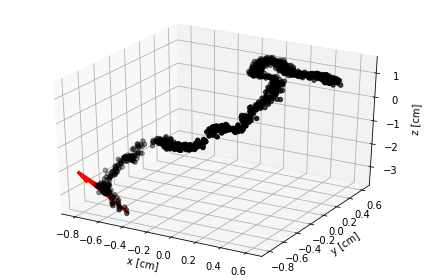

In [5]:
# Isolate a track
track = df.iloc[2]

# Plot the track
plot_track_dir(track['x'], track['y'], track['z'], track['offset'], track['dir'])

In [229]:
# Method for determining the initial direction of an electron recoil without ML
# refs:
# https://iopscience.iop.org/article/10.3847/1538-3881/ac51c9/pdf
# https://lucidar.me/en/mathematics/weighted-pca/
def non_ML(x_vals, y_vals, z_vals, charges, n_sigma_L = 1.5, n_sigma_H = 3, w_o = 0.05):

    X = np.array([x_vals,y_vals,z_vals]).T

    # 1) Center on barycenter
    x_b = np.sum(X*(charges.reshape(len(charges),1)),axis=0)/np.sum(charges)
    X = X-x_b

    # 2) Find principle axis
    v_PA, dd, datamean = fitsvd (x_vals, y_vals, z_vals)
    # 2)a. Compute second moment about principle axis 
    X_proj = X@v_PA
    M_2 = np.sum( charges * ( X_proj**2 ) ) / np.sum(charges)
    # 2)b. Compute third moment about principle axis 
    M_3 = np.sum( charges * ( X_proj**3 ) ) / np.sum(charges)

    # 3) keep only points where projected sign is same sgn(M3) and n_sigma_L M_2 <|proj_i| < n_sigma_H M2
    X_IR = X [ (np.sign(X_proj) == np.sign(M_3)) & ( (n_sigma_L*M_2) <  np.abs(X_proj) ) & (np.abs(X_proj) < (n_sigma_H*M_2))]
    charges_IR = charges [ (np.sign(X_proj) == np.sign(M_3)) & ( (n_sigma_L*M_2) <  np.abs(X_proj) ) & (np.abs(X_proj) < (n_sigma_H*M_2))]

    # 4) find the interaction point
    x_IP = np.sum(X_IR*(charges_IR.reshape(len(charges_IR),1)),axis=0)/np.sum(charges_IR)

    # 5) Find the final direction
    # Center on interaction point
    X_IR = X_IR-x_IP
    # re-weight charges
    charges_IR = charges_IR * np.exp(-1*np.linalg.norm(X_IR,axis=1)/w_o)
    # Re-shape weights
    W = charges_IR.reshape(len(charges_IR),1)
    # computed weighted covariance matrix
    WCM = ( (W*X_IR).T @ X_IR ) / np.sum(W)
    # run SVD
    U,S,D = np.linalg.svd(WCM)

    v_IP = np.array([D[0][0],D[0][1],D[0][2]])

    # Assign v_PA the correct head/tail
    v_PA = -1.0*np.sign(M_3)*v_PA
    # Assign v_IP the direction which most agrees with v_PA
    v_IP = np.sign( np.dot(v_IP,v_PA) ) * v_IP

    # Extract and return principle axis of interaction region
    return v_IP






In [230]:
x_vals, y_vals, z_vals = track.x, track.y, track.z 
charges =np.ones(len(x_vals))

v_IP = non_ML(x_vals, y_vals, z_vals, charges)

In [231]:
# 3) keep only points where projected sign is same sgn(M3) and 1.5 M_2 <|proj_i| < 3 M2
x2 = x_vals[ (np.sign(X_proj) == np.sign(M_3)) & ( (1.5*M_2) <  np.abs(X_proj) ) & (np.abs(X_proj) < (3*M_2))]
y2 = y_vals[ (np.sign(X_proj) == np.sign(M_3)) & ( (1.5*M_2) <  np.abs(X_proj) ) & (np.abs(X_proj) < (3*M_2))]
z2 = z_vals[ (np.sign(X_proj) == np.sign(M_3)) & ( (1.5*M_2) <  np.abs(X_proj) ) & (np.abs(X_proj) < (3*M_2))]

X_IR = X [ (np.sign(X_proj) == np.sign(M_3)) & ( (1.5*M_2) <  np.abs(X_proj) ) & (np.abs(X_proj) < (3*M_2))]


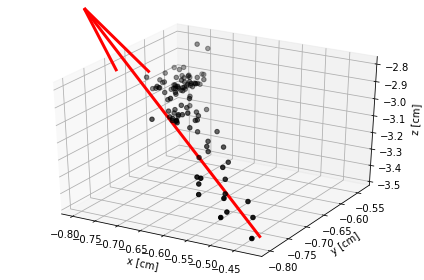

In [234]:
# Plot the track
plot_track_dir(x2, y2, z2, track['offset'], track['dir'])

In [224]:
X = np.array([x_vals,y_vals,z_vals]).T
X

array([[ 0.54991238,  0.40919923,  0.95028904],
       [-0.42953781, -0.80200312, -3.4672392 ],
       [-0.4573502 , -0.76397823, -3.41292554],
       ...,
       [-0.09161108,  0.41768643,  0.92455073],
       [-0.03550637,  0.43010055,  0.93540885],
       [ 0.43634468,  0.45475266,  1.0260184 ]])

In [222]:
charges.reshape(len(charges),1)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [228]:
np.sum(X*(charges.reshape(len(charges),1)),axis=0)/np.sum(charges)

array([ 5.01441592e-17,  6.51874070e-17, -1.60461309e-16])

In [212]:
X_IR * charges_IR

ValueError: operands could not be broadcast together with shapes (102,3) (1,102) 

In [130]:
np.mean(X_IR.T,axis=1)

array([-0.69317246, -0.64325393, -3.05367715])

In [112]:
( (1.5*M_2) <  np.abs(X_proj) ) & (np.abs(X_proj) < (3*M_2))

array([False,  True,  True, ..., False, False, False])

In [106]:
X_proj < (3*M_)2

array([-1.12361895,  3.55947942,  3.50451435, ..., -0.95851433,
       -0.98458749, -1.18151857])

In [50]:
&  ( (1.5*M_2) < np.sign(X_proj) ) & (np.sign(X_proj) < (3*M_2))X

array([[ 0.54991238,  0.40919923,  0.95028904],
       [-0.42953781, -0.80200312, -3.4672392 ],
       [-0.4573502 , -0.76397823, -3.41292554],
       ...,
       [-0.09161108,  0.41768643,  0.92455073],
       [-0.03550637,  0.43010055,  0.93540885],
       [ 0.43634468,  0.45475266,  1.0260184 ]])

In [62]:
weights * (X@v_PA)

array([-1.12361895,  3.55947942,  3.50451435, ..., -0.95851433,
       -0.98458749, -1.18151857])

In [63]:
np.sum( weights * ( (X@v_PA)*(X@v_PA) ) ) / np.sum(weights)

1.9400666990644377

In [47]:
# Find principal axis method 1
dir, dd, datamean = fitsvd (x_vals, y_vals, z_vals)
dir

array([-0.22340638, -0.27190541, -0.93603261])

In [48]:
dd

array([52.43161749,  9.45807566,  5.53141651])

In [164]:
# Find principal axis method 2
X = np.array([x_vals,y_vals,z_vals]).T
W = weights.reshape(len(weights),1)

WCM = (((W*X).T)@X)/np.sum(W)
U,S,D = np.linalg.svd(WCM)

dir = np.array([D[0][0],D[0][1],D[0][2]])

In [165]:
W

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [45]:
U,S,D = np.linalg.svd(WCM)

dir = np.array([D[0][0],D[0][1],D[0][2]])

In [46]:
dir

array([-0.22340638, -0.27190541, -0.93603261])

In [221]:
# this treatment does not includes weights (charge)

# Specify parameters of algorithim 
N_pt = 100
w_p = 2

#Find barycenter
Bc = np.array([np.mean(track.x),np.mean(track.y),np.mean(track.z)])



In [222]:
# radius [cm]
r_opt = 0
for r in np.arange(0,5,0.0001):

    N = np.sum( ( (track.x-Bc[0])**2 + (track.y-Bc[1])**2 + (track.z-Bc[2])**2 ) > r**2)

    if N == N_pt:
        r_opt = r
        break

filter = ( (track.x-Bc[0])**2 + (track.y-Bc[1])**2 + (track.z-Bc[2])**2 ) > r_opt**2

r_opt




2.2706

In [223]:
x_IP = track.x[filter]
y_IP = track.y[filter]
z_IP = track.z[filter]

# Weights, will need to multiply this by charge in the end
W = np.exp(-1.0 * np.sqrt(x_IP**2+y_IP**2+z_IP**2) / w_p)



# Need to include weight treatement here
dir, dd, datamean =fitsvd(x_IP,y_IP,z_IP)

In [226]:
x = np.array(x_IP)
y = np.array(y_IP)
z = np.array(z_IP)

data = np.concatenate((x[:, np.newaxis], 
                        y[:, np.newaxis], 
                        z[:, np.newaxis]), 
                        axis=1)

# Calculate the mean of the points, i.e. the 'center' of the cloud
datamean = data.mean(axis=0)

uu, dd, vv = np.linalg.svd(data - datamean)

In [230]:
data - datamean

array([[-5.90097993e-01, -1.91888154e-01, -1.15607347e-01],
       [-5.21458617e-01, -2.36868346e-01, -1.22169718e-01],
       [-6.01518918e-01, -1.86624737e-01, -1.33111038e-01],
       [-4.91358162e-01, -1.28556365e-01, -1.01803333e-01],
       [-4.12139885e-01, -1.71789983e-01, -1.22349589e-01],
       [-4.87773183e-01, -1.61210737e-01, -1.35123447e-01],
       [-3.88815561e-01, -1.10328564e-01, -1.36819635e-01],
       [-3.61448925e-01, -1.05437213e-01, -9.46436788e-02],
       [-3.60097562e-01, -8.87566964e-02, -1.26775955e-01],
       [-2.85769287e-01, -1.03906012e-01, -9.49581406e-02],
       [-2.75317675e-01, -6.40898751e-02, -1.24422695e-01],
       [-2.87702711e-01, -5.14238268e-02, -1.34533645e-01],
       [-2.05761400e-01, -5.39626888e-02, -1.12075145e-01],
       [-2.04953962e-01, -2.02917340e-02, -1.20792492e-01],
       [-1.42614241e-01, -3.75777245e-02, -1.10750408e-01],
       [-1.81189676e-01, -7.99160352e-03, -1.11386885e-01],
       [-1.93010360e-01, -4.25643659e-02

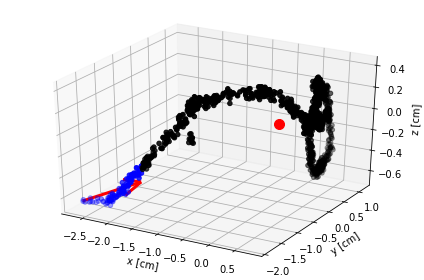

In [212]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')



# Plot points not in IP
ax.scatter3D(track.x[~filter], track.y[~filter], track.z[~filter], c='k', marker='o')

# Plot points in IP
ax.scatter3D(x_IP, y_IP, z_IP, c='b', marker='o')

# Plot baryceneter
ax.scatter3D(Bc[0], Bc[1], Bc[2], c='r', marker='o', s=100)

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
plt.tight_layout()

# Add red line for true direction (z direction)
#ax.plot3D([vector_tail[0],vector_head[0]], [vector_tail[1],vector_head[1]], [vector_tail[2],vector_head[2]], c='r')
ax.quiver(track['offset'][0],track['offset'][1],track['offset'][2],track['dir'][0],track['dir'][1],track['dir'][2], linewidths=3, color = 'red')